# 루브릭
1. 다양한 방법으로 Text Classification Task를 성공적으로 구현하였다.
    - 3가지 이상의 모델이 성공적으로 시도됨.
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
    - gensim의 유사단어 찾기를 활용하여 자체학습된 임베딩과 사전학습 임베딩을 비교 분석함.
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함.

### 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


### 데이터 불러오기

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print("train data의 개수 : {}, test data의 개수 : {}".format(len(train_data), len(test_data)))

train data의 개수 : 150000, test data의 개수 : 50000


In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    #train data 전처리 과정으로 중복, 공백 NULL로 변경, 특수문자제거, 결측치 제거
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'].replace(" ", np.nan, inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data = train_data.dropna(how = 'any') 
    
    # test data전처리 과정으로 중복, 공백Null변경, 특수문자제거,결측치제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'].replace(" ", np.nan, inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전 구성
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
   
    # 텍스트 -> 인덱스로 변환 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] # 사전에 없는 단어 처리
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_129/161509343.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_129/161509343.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 진짜 짜증 나 네요 목소리
라벨:  0


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  13.718233430088207
문장길이 최대 :  83
문장길이 표준편차 :  11.469848902034261
pad_sequences maxlen :  36
전체 문장의 93.40019146202243%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

하이퍼 파라미터 수정 및 성능 확인을 위해 Validation 분리

In [10]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(136182, 36)
(136182,)
(10000, 36)
(10000,)


## 모델 구현하기
사용할 3가지의 모델은 기본 LSTM와 개인적으로 NLP를 공부하다 알게된 Bidirectional LSTM과 LMS에 이야기 된 1-D Conv을 이용할 것 입니다.
### 1. LSTM

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # epoch은 20을 진행 후 어떤 값이 적절할지 지정함.

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 14s 5ms/step - loss: 0.4142 - accuracy: 0.8016 - val_loss: 0.3519 - val_accuracy: 0.8428
Epoch 2/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3391 - accuracy: 0.8511 - val_loss: 0.3517 - val_accuracy: 0.8442
Epoch 3/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3115 - accuracy: 0.8631 - val_loss: 0.3425 - val_accuracy: 0.8463
Epoch 4/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2879 - accuracy: 0.8742 - val_loss: 0.3471 - val_accuracy: 0.8513
Epoch 5/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2695 - accuracy: 0.8832 - val_loss: 0.3444 - val_accuracy: 0.8512


In [13]:
history = history.history

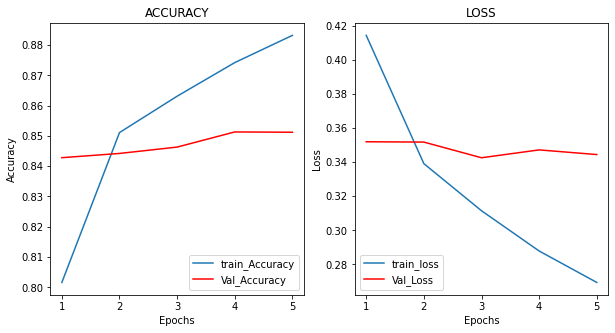

In [14]:
import matplotlib.pyplot as plt

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 3s 7ms/step - loss: 0.2364 - accuracy: 0.9001 - val_loss: 0.3636 - val_accuracy: 0.8482
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2259 - accuracy: 0.9048 - val_loss: 0.3851 - val_accuracy: 0.8482
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2157 - accuracy: 0.9084 - val_loss: 0.4005 - val_accuracy: 0.8455
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2051 - accuracy: 0.9140 - val_loss: 0.4220 - val_accuracy: 0.8455
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1964 - accuracy: 0.9166 - val_loss: 0.4348 - val_accuracy: 0.8434


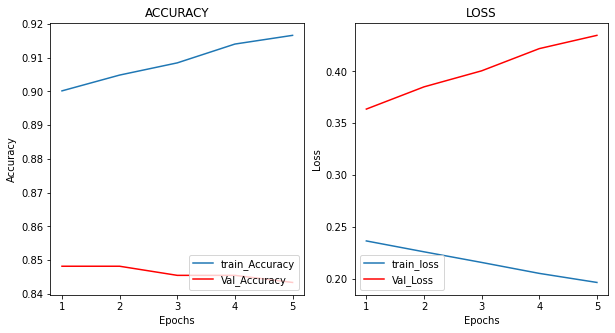

In [16]:
history = history.history

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

batch size를 62와 512로 다르게 해서 실험을 해보았습니다. 그래프로 봤을 땐 구분이 가지 않지만 값을 비교 해보면 batch size가 512일 때 학습을 더 잘함을 알 수 있습니다.

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4439 - accuracy: 0.8389
[0.4438660144805908, 0.8389446139335632]


그럼에도 원하는 결과 값인 0.85에 비해 0.12정도 부족합니다,,,

### 2. Bidirectional LSTM

In [18]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(8, return_sequences = False), input_shape = (49,1)))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1600      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 161,745
Trainable params: 161,745
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 5s 10ms/step - loss: 0.5014 - accuracy: 0.7628 - val_loss: 0.3638 - val_accuracy: 0.8409
Epoch 2/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3595 - accuracy: 0.8477 - val_loss: 0.3490 - val_accuracy: 0.8443
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3356 - accuracy: 0.8572 - val_loss: 0.3467 - val_accuracy: 0.8434
Epoch 4/5
266/266 [==============================] - 2s 8ms/step - loss: 0.3203 - accuracy: 0.8619 - val_loss: 0.3493 - val_accuracy: 0.8444
Epoch 5/5
266/266 [==============================] - 2s 7ms/step - loss: 0.3071 - accuracy: 0.8670 - val_loss: 0.3534 - val_accuracy: 0.8427


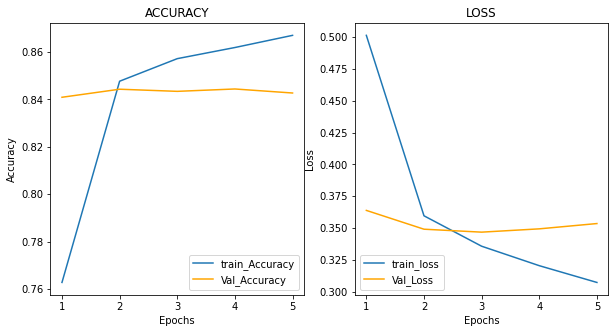

In [21]:
history = history.history

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'orange', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.3643 - accuracy: 0.8384
[0.3642539083957672, 0.8383750319480896]


양방향 LSTM을 이용하면 조금 더 결과가 좋게 나올 것이라 생각했지만, 그렇지 않았습니다. test accuracy는 거의 유사하게 나왔습니다.

## 3. 1-D CNN

In [23]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [24]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 17s 6ms/step - loss: 0.5265 - accuracy: 0.7428 - val_loss: 0.3732 - val_accuracy: 0.8333
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3456 - accuracy: 0.8509 - val_loss: 0.3535 - val_accuracy: 0.8438
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3098 - accuracy: 0.8693 - val_loss: 0.3541 - val_accuracy: 0.8428
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2834 - accuracy: 0.8829 - val_loss: 0.3595 - val_accuracy: 0.8425
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2591 - accuracy: 0.8947 - val_loss: 0.3729 - val_accuracy: 0.8406


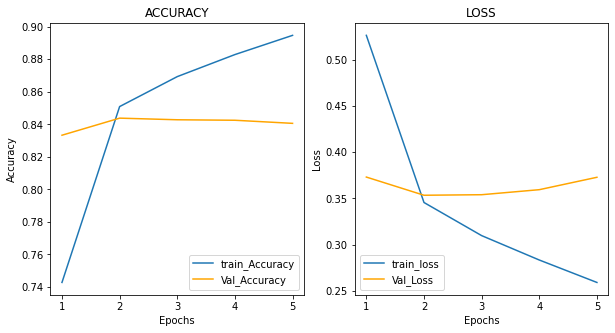

In [25]:
history = history.history

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'orange', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3806 - accuracy: 0.8378
[0.3805653154850006, 0.8377850651741028]


1-D Conv 또한 유사한 결과를 내었음을 볼 수 있습니다.

#### Word Embedding

In [27]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [28]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("공부")

[('역겨운', 0.9104198813438416),
 ('오징어', 0.9072514176368713),
 ('더글라스', 0.8889743685722351),
 ('정준', 0.8882479071617126),
 ('거미', 0.8867976069450378),
 ('다인', 0.8860538005828857),
 ('읎', 0.8855109214782715),
 ('가려', 0.8815740346908569),
 ('랜턴', 0.8810878396034241),
 ('편승', 0.875722348690033)]

Word Embedding을 통해 '공부'와 유사한 단어를 뽑아내 보았습니다. 하지만 대부분이 '공부'라는 단어와 유사하지 않음을 알 수 있었습니다.
그래서 이번에는 Word2Vec를 이용할 것이며, pre-train된 모델을 가져와 실험을 진행해보도록 하겠습니다.

### Word2Vec Embedding

In [39]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path).wv
vector = word2vec['공부']
vector.shape


(100,)

In [41]:
word2vec.most_similar('공부')

[('중퇴', 0.7482234835624695),
 ('전공', 0.728223979473114),
 ('자퇴', 0.7157790660858154),
 ('졸업', 0.7004087567329407),
 ('가르치', 0.6782639622688293),
 ('수료', 0.6718839406967163),
 ('수학', 0.6572521328926086),
 ('유학', 0.6553082466125488),
 ('입학', 0.6530455350875854),
 ('집필', 0.6526979207992554)]

이번에는 Word Embedding과는 달리 '공부'와 유사한 단어가 잘 나오고 있음을 알 수 있습니다.
이를 통해 깨달은 것은 데이터의 양이 많아야 한다는 것을 새삼 느낄 수 있었습니다.

In [44]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [45]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
2128/2128 [==============================] - 13s 5ms/step - loss: 0.4363 - accuracy: 0.7843 - val_loss: 0.3501 - val_accuracy: 0.8419
Epoch 2/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.3158 - accuracy: 0.8622 - val_loss: 0.3177 - val_accuracy: 0.8587
Epoch 3/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2774 - accuracy: 0.8807 - val_loss: 0.3131 - val_accuracy: 0.8607
Epoch 4/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2462 - accuracy: 0.8961 - val_loss: 0.3168 - val_accuracy: 0.8613
Epoch 5/5
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2166 - accuracy: 0.9099 - val_loss: 0.3465 - val_accuracy: 0.8620


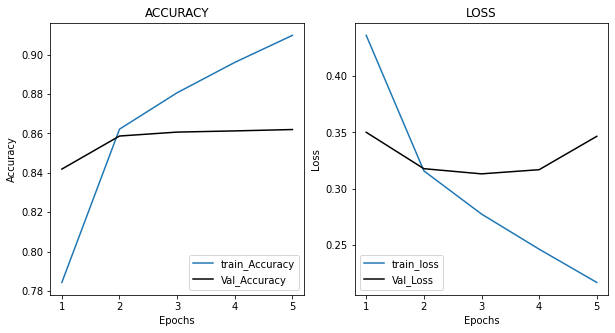

In [50]:
history = history.history

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='train_Accuracy')
plt.plot(epochs, val_acc, 'black', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, 'black', label='Val_Loss')
plt.legend(loc='lower left')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3560 - accuracy: 0.8587
[0.3559631407260895, 0.8587383031845093]


사전 학습된 모델을 사용하니 그렇게 눈에 띄는 결과를 보여준 것은 아니지만 목표 결과인 0.85에 도달했음을 확인할 수 있었습니다.<br>
무엇보다 gensim을 이용하는데 있어 조금 고생을 한 부분이 있었습니다.
local환경에서 시도할 때, gensim을 설치하는 과정이 꽤나 힘이 들었습니다. 물론 이를 LMS에서 하면 쉽게 진행이 가능했습니다.
그리고 데이터의 중요성을 새삼 느끼게 되었습니다. 데이터가 잘 정제되어야 함도 맞지만 그만큼 방대한 양의 데이터가 있으면 학습도 잘 된다는 점입니다.